<span style="color: red"> This is one of the solutions posted on Kaggle (https://www.kaggle.com/code/ibrahimahmed26/emotion-detection-nlp-mental-health/notebook), downloaded to understand how others have approached similar problem</span>

Here the developer compares a pre-trained model value against RandomForestClassifier value. Here are the steps that are used : 
- determines Y using a pre-trained model
- Splits the data along with the new Y
- Uses TDIF to convert text to Vector 
- Uses RandomForestClassifier as the model to predict new values.

# Introduction

In recent years, mental health awareness has grown, leading to a greater emphasis on making support more accessible to everyone. Artificial Intelligence (AI) is playing a pivotal role in bridging the gap between those in need of mental health advice and the limited number of qualified professionals available. The dataset provided in this project is a valuable resource for developing Natural Language Processing (NLP) models that can assist with mental health support.

The dataset used in this project consists of anonymized conversations between patients and experienced psychologists, where we will concentrate on detecting the emotional context of the dialogue. By understanding the emotions present in these exchanges, the NLP model will be able to respond more appropriately and offer tailored advice based on the patient's emotional state.

## Purpose

The notebook will explore, preprocess, and model the data with the goal of improving emotion detection in patient conversations. This will allow us to understand the emotional landscape of mental health discussions and create AI systems capable of providing emotionally aware responses.

# Libraries

In [2]:
#Download and Extracting Data from Kaggle
import os
import zipfile


# Data Preprcessing
import string
import re
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

#Label Encouding
from sklearn.preprocessing import LabelEncoder
# from textblob import Word, TextBlob
# from wordcloud import WordCloud

#Feature Extracting
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  # Download the wordnet corpus for lemmatization

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sambapedapalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sambapedapalli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sambapedapalli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data

## Download and Extracting

In [4]:
# Downlaod the dataset using kaggle API
os.system("kaggle datasets download -d thedevastator/nlp-mental-health-conversations")

#Extract the download zip files
dataset_zip='nlp-mental-health-conversations.zip'
extracted_folder='nlp_mental_health_conversations'

#Extract the dataset
with zipfile.ZipFile(dataset_zip,'r') as zip_ref:
  zip_ref.extractall(extracted_folder)

print("Dataset downloaded and extracted successfully.")

Dataset URL: https://www.kaggle.com/datasets/thedevastator/nlp-mental-health-conversations
License(s): CC0-1.0

Dataset downloaded and extracted successfully.


100%|██████████| 1.48M/1.48M [00:00<00:00, 1.44GB/s]


## Explore Data

In [5]:
data=pd.read_csv("./nlp_mental_health_conversations/train.csv")

In [6]:
data.head()

,Context,Response
0,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How can I change my feeling of being worthless to everyone?","If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part of living. They are the motivation to remove ourselves from situations and relationships which do us more harm than good.Bad feelings do feel terrible. Your feeling of worthlessness may be good in the sense of motivating you to find out that you are much better than your feelings today."
1,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How can I change my feeling of being worthless to everyone?","Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People often try thinking positive thoughts, debating with their thoughts, or simply telling themselves that they need to ""snap out of it"" - which is also a thought that carries some self-criticism. Some people try a different approach, and there are counselors out there that can help you with this. The idea is that instead of trying to change the thoughts, you change how you respond to them. You learn skills that allow you to manage difficult thoughts and feelings differently so they don't have the same impact on you that they do right now. For some people, they actually DO begin to experience less hurtful thoughts once they learn how to manage the ones they have differently. Acceptance and Commitment Therapy may be a good choice for you. There is information online and even self-help books that you can use to teach you the skills that I mentioned. Because they are skills, they require practice, but many people have found great relief and an enriched life by learning them. As for suicidal thoughts, I am very glad to read that this has not happened to you. Still, you should watch out for this because it can be a sign of a worsening depression. If you begin to think about this, it is important to reach out to a support system right away. The National Suicide Prevention Lifeline is 1-800-273-8255. The text line is #741741. I hope some other colleagues will provide you more suggestions. Be well...Robin Landwehr, DBH, LPCC"
2,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How

In [9]:
reponse=data.loc[0,"Response"]
print("Length Before text preprocessing : ",len(reponse))

Length Before text preprocessing :  961


## Text Preprocessing
- Normlaize
- Punctuation
- Numbers
- StopWords
- Lemmezation
- Removing Words

In [10]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to string
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    return ' '.join(tokens)

# Apply the clean_text function to your 'Context' column
data['Context'] = data['Context'].apply(clean_text)

In [11]:
# Remove Rarewords:

# Let's remove words used less than 1
temp_Context = pd.Series(' '.join(data['Context']).split()).value_counts()
drops = temp_Context[temp_Context <= 1]
data['Context'] = data['Context'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

## Text visualization

In [12]:
tf_Context = data["Context"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf_Context.columns = ["words", "tf"]
tf_Context.sort_values("tf", ascending=False)

,words,tf
0,im,1639.00
23,’,1522.00
65,feel,1331.00
64,like,1175.00
178,dont,1078.00
...,...,...
2452,free,2.00
2453,romantically,2.00
2455,invisible,2.00
1457,location,2.00


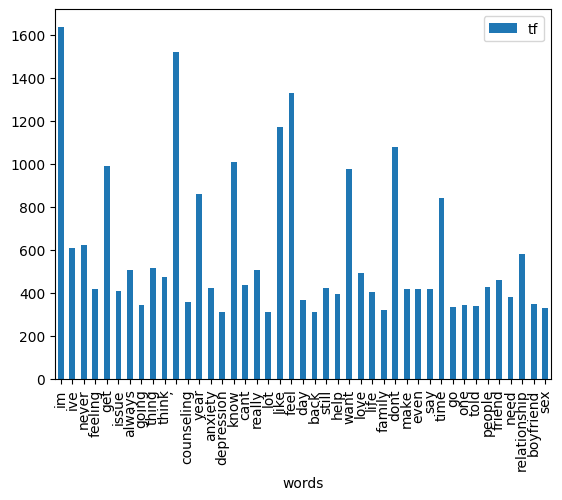

In [13]:
# Barplot for Context

tf_Context[tf_Context["tf"] > 300].plot.bar(x="words", y="tf")
plt.show()

# Emotions Anaylsis

In [14]:
from transformers import pipeline

In [15]:
# Extract and clean 'Context' column
contexts = data['Context']

# Load pre-trained emotion detection model
emotion_model = pipeline('sentiment-analysis', model='j-hartmann/emotion-english-distilroberta-base')

# Analyze emotions in 'Context'
emotions = contexts.apply(lambda x: emotion_model(x)[0]['label'])

# Add detected emotions as a new column
data['Detected_Emotion'] = emotions

Device set to use mps:0


In [16]:
data.head()

,Context,Response,Detected_Emotion
0,im going thing feeling barely sleep nothing think im worthless shouldnt ive never tried contemplated suicide ive always wanted fix issue never get around change feeling worthless everyone,"If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part of living. They are the motivation to remove ourselves from situations and relationships which do us more harm than good.Bad feelings do feel terrible. Your feeling of worthlessness may be good in the sense of motivating you to find out that you are much better than your feelings today.",sadness
1,im going thing feeling barely sleep nothing think im worthless shouldnt ive never tried contemplated suicide ive always wanted fix issue never get around change feeling worthless everyone,"Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People often try thinking positive thoughts, debating with their thoughts, or simply telling themselves that they need to ""snap out of it"" - which is also a thought that carries some self-criticism. Some people try a different approach, and there are counselors out there that can help you with this. The idea is that instead of trying to change the thoughts, you change how you respond to them. You learn skills that allow you to manage difficult thoughts and feelings differently so they don't have the same impact on you that they do right now. For some people, they actually DO begin to experience less hurtful thoughts once they learn how to manage the ones they have differently. Acceptance and Commitment Therapy may be a good choice for you. There is information online and even self-help books that you can use to teach you the skills that I mentioned. Because they are skills, they require practice, but many people have found great relief and an enriched life by learning them. As for suicidal thoughts, I am very glad to read that this has not happened to you. Still, you should watch out for this because it can be a sign of a worsening depression. If you begin to think about this, it is important to reach out to a support system right away. The National Suicide Prevention Lifeline is 1-800-273-8255. The text line is #741741. I hope some other colleagues will provide you more suggestions. Be well...Robin Landwehr, DBH, LPCC",sadness
2,im going thing feeling barely sleep nothing think im worthless shouldnt ive never tried contemplated suicide ive always wanted fix issue never get around change feeling worthless everyone,First thing I'd suggest is getting the sleep you need or it will impact how you think and feel. I'd look at finding what is going well in your life and what you can be grateful for. I believe everyone has talents and wants to find their purpose in life. I think you can figure it out with some help.,sadness
3,im going thing feeling

In [17]:
data['Detected_Emotion'].value_counts()

Detected_Emotion
sadness     1338
fear         891
anger        539
neutral      321
joy          231
surprise     169
disgust       23
Name: count, dtype: int64

# Feature Extraction

In [18]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(contexts)

# Convert to array (if needed)
tfidf_array = tfidf_matrix.toarray()

# Model

## Data Spilting

In [19]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(tfidf_array, data['Detected_Emotion'], test_size=0.3, random_state=42)


In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
# Initialize the model
model = RandomForestClassifier()

## Fine Tuning

In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best parameters: {grid_search.best_params_}')


Best parameters: {'max_depth': None, 'n_estimators': 200}


# Train and Evaluation

## Train

In [20]:
model = RandomForestClassifier()
# Train the model
model.fit(X_train, y_train)

RandomForestClassifier()

## Evaluation

Accuracy: 0.9392789373814042

Classification Report:

              precision    recall  f1-score   support



       anger       0.96      0.91      0.93       160

     disgust       1.00      0.67      0.80         6

        fear       1.00      0.95      0.97       275

         joy       1.00      0.82      0.90        68

     neutral       0.93      0.95      0.94        85

     sadness       0.89      0.99      0.93       412

    surprise       1.00      0.77      0.87        48



    accuracy                           0.94      1054

   macro avg       0.97      0.86      0.91      1054

weighted avg       0.94      0.94      0.94      1054



Confusion Matrix:

[[145   0   0   0   1  14   0]

 [  0   4   0   0   0   2   0]

 [  2   0 261   0   2  10   0]

 [  0   0   0  56   0  12   0]

 [  1   0   0   0  81   3   0]

 [  3   0   0   0   3 406   0]

 [  0   0   0   0   0  11  37]]


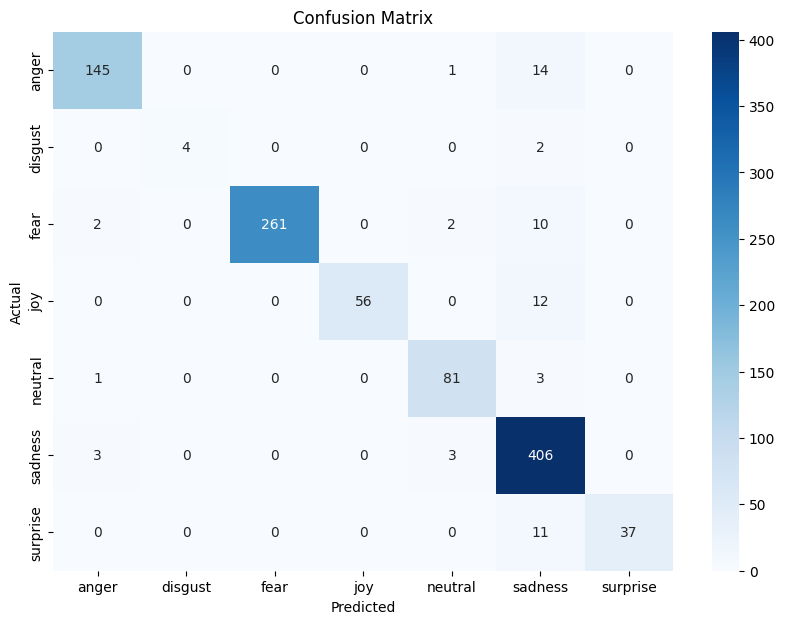

In [21]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Test Unseen Data

In [22]:
# Example new text
new_text = ["let's leave i am scared"]

# Clean and transform the new text
new_text_cleaned = [clean_text(text) for text in new_text]
new_text_tfidf = vectorizer.transform(new_text_cleaned)

# Predict emotion
predicted_emotion = model.predict(new_text_tfidf)
print(predicted_emotion)


['fear']
